In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (4,2.5)
import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 8
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import GPy
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

# Generating data

In [2]:
var = 100
lengthscale = 0.12
total_num_of_dots = 500
start_num_of_dots = 10
end_num_of_dots = 300
test_size = 200

Text(0,0.5,'$f(x)$')

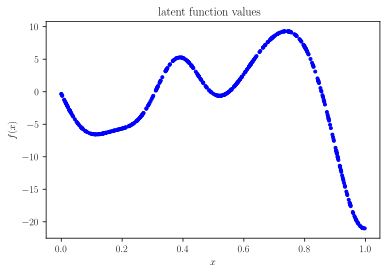

In [3]:
k = GPy.kern.RBF(1, variance=var, lengthscale=lengthscale)
X = np.random.rand(total_num_of_dots, 1)

#draw the latent function value
f = np.random.multivariate_normal(np.zeros(total_num_of_dots), k.K(X))

plt.plot(X, f, 'b.')
plt.title('latent function values')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

Text(0,0.5,'$\\sigma(f(x))$')

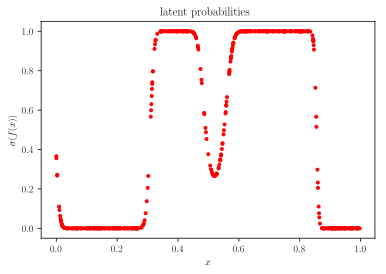

In [4]:
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f) # squash the latent function
plt.plot(X, p, 'r.')
plt.title('latent probabilities');plt.xlabel('$x$');plt.ylabel('$\sigma(f(x))$')

Text(0,0.5,'$y \\in \\{0,1\\}$')

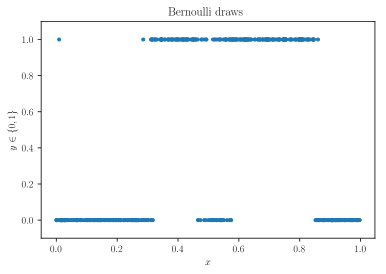

In [5]:
Y = lik.samples(f).reshape(-1,1)
plt.plot(X, Y, '.');plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws');plt.xlabel('$x$');plt.ylabel('$y \in \{0,1\}$')

# Creating train dataset

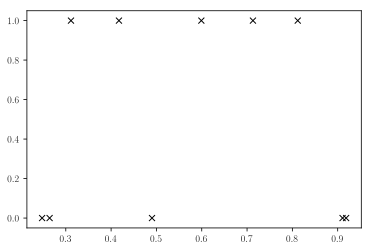

In [6]:
from sklearn.model_selection import train_test_split
U, X_train, y_U, y_train = train_test_split(X, Y, test_size = start_num_of_dots)
U, X_test, y_U, y_test = train_test_split(X, Y, test_size = test_size)

plt.plot(X_train, y_train, 'kx')

# An example Inference
To see whether gaussian process lerns on the data

In [7]:
m = GPy.core.GP(X=X_train,
                Y=y_train, 
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)

Text(0.5,0,'$x$')

 /home/daria.kotova/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


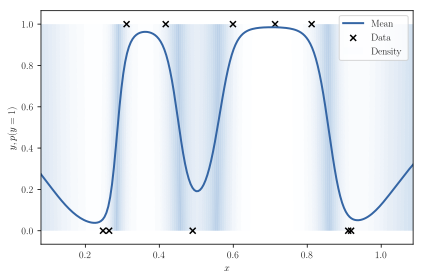

In [8]:
m.plot(plot_density = True)
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')

(<GPy.core.gp.GP object at 0x7fc11b83e590>, '\n')


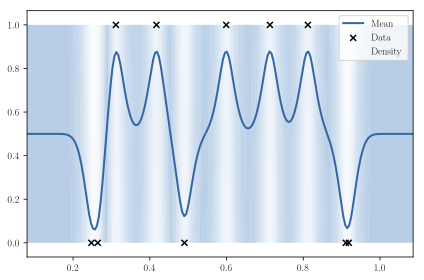

In [9]:
for i in range(5):
    m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters

print(m, '\n')
m.plot(plot_density = True)

m_optimized = m

# Preparation for actually experiments

In [10]:
#create structure of folders to store plots for different score_functions
!rm -r score_plots
!mkdir score_plots

!mkdir ./score_plots/rand
!mkdir ./score_plots/vari
!mkdir ./score_plots/sqsm
!mkdir ./score_plots/RKHS
!mkdir ./score_plots/Hvar
!mkdir ./score_plots/l2fm

# Active learning part

In [11]:
# scores.py contains score-calculation functions
import scores
import utils

In [12]:
def to_labels(a):
    for i in range(len(a)):
        a[i] = 1 if a[i][0] >= 0.5 else 0
        
    return a

In [13]:
def draw_score(scores, U, score_name, iteration, m, X_train, y_train):
    scores = np.array(scores)
    order = np.argsort(U, axis = 0)
    
    U = np.array(U)[order].reshape(-1, 1)
    
    scores = (np.array(scores)[order]).reshape(-1, 1)
    
    plt.clf()
    plt.plot(U, scores)
    plt.plot(X_train[-1], max(scores), 'go')
    
    open(score_name + str(iteration) + 'score' + '.png', 'w+')
    plt.savefig(score_name + str(iteration) + 'score' + '.png')
    
    plt.clf()
    plt.plot(X, p, 'r.')
    plt.plot(X_train[-1], y_train[-1], 'go')
    
    open(score_name + str(iteration) + 'prob' + '.png', 'w+')
    plt.savefig(score_name + str(iteration) + 'prob' + '.png')

# Learning cycle
Train 5 gps with different score function

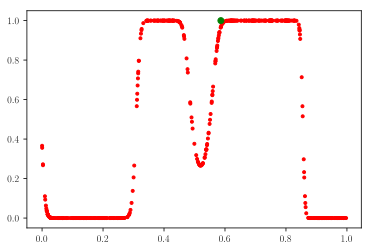

In [14]:
acc_rand = []
acc_vari = []
acc_sqsm = []
acc_RKHS = []
acc_Hvar = []
acc_l2fm = []

models = []

X_train_0   = X_train
y_train_0   = y_train
U_0         = U
y_U_0       = y_U
 
for score, acc in (zip((scores.calculate_scores_rand, scores.calculate_scores_vari, 
                            scores.calculate_scores_sqsm, scores.calculate_scores_RKHS, 
                            scores.calculate_scores_Hvar, scores.calculate_scores_l2fm),
                            (acc_rand, acc_vari, acc_sqsm, acc_RKHS, acc_Hvar, acc_l2fm))):
    X_train = X_train_0
    y_train = y_train_0
    U = U_0
    y_U = y_U_0
    
    k = GPy.kern.RBF(1, variance=var, lengthscale=lengthscale)
    m = GPy.core.GP(X=X_train,
                    Y=y_train, 
                    kernel=k, 
                    inference_method=GPy.inference.latent_function_inference.Laplace(),
                    likelihood=lik)
    
    K = utils.get_K(m, X_train)
    inv_K = utils.get_inv_K(m, X_train)
    
    for i in tqdm(range(start_num_of_dots, end_num_of_dots)):
        #0. learn GP on the data
        m = GPy.core.GP(X=X_train,
                        Y=y_train, 
                        kernel=k, 
                        inference_method=GPy.inference.latent_function_inference.Laplace(),
                        likelihood=lik)

        #1. calculate score at each point of the rest dataset in U and y_u, get the ind of maximum
        scores = score(np.array(U), m, X_train, y_train, inv_K)
        ind = np.argmax(scores)
        
        #2. append new point to the training dataset and remove it from U
        X_train = np.append(X_train, U[ind]).reshape(-1, 1)
        y_train = np.append(y_train, y_U[ind]).reshape(-1, 1)
     
        a = m.kern.K(np.expand_dims(np.array(U[ind]), 1), X_train[:X_train.shape[0]-1]).T
        
        inv_K = utils.update_inv_K(m, X_train, inv_K, U[ind], a)

        #placing this function call right here is important
        #since draw_score should see whole U included the point to be deleted
        draw_score(scores, U, "./score_plots/"+str(score)[27:31]+"/", i, m, X_train, y_train)

        U = np.delete(U, ind).reshape(-1, 1)
        y_U = np.delete(y_U, ind)

        #3. count accuracy and log_loss
        acc.append(accuracy_score(y_test, to_labels(m.predict(X_test.reshape(-1, 1))[:][0])))
        
    #after the gp is learned save it to models
    models.append(m)
            


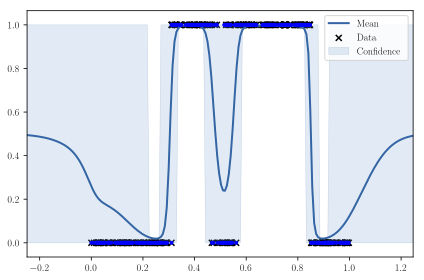

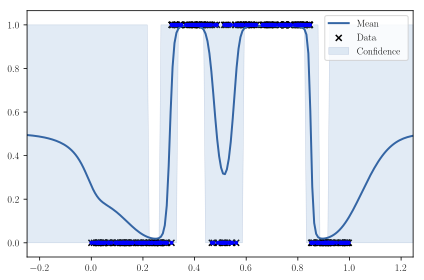

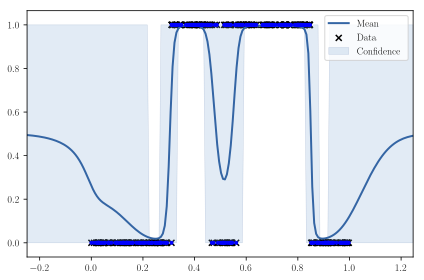

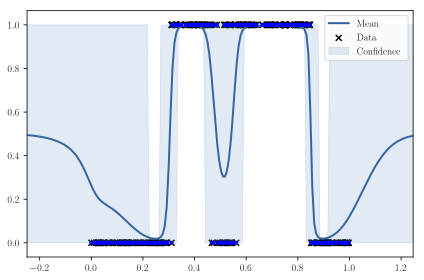

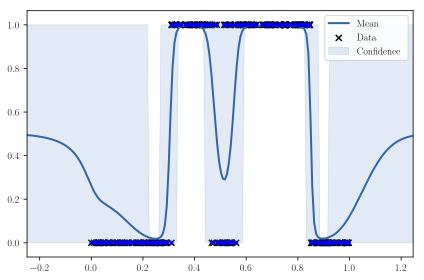

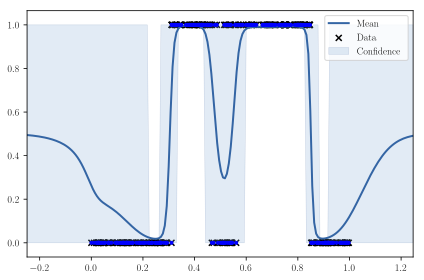

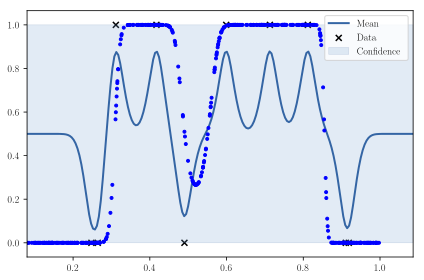

In [15]:
for m in models:
    m.plot()
    plt.plot(X_train, y_train, 'b.')

m_optimized.plot()
plt.plot(X, p, 'b.')

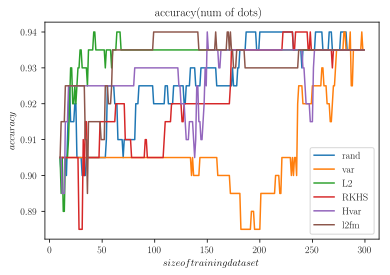

In [16]:
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_rand[:len(acc_rand)], label='rand')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_vari[:len(acc_rand)], label='var')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_sqsm[:len(acc_rand)], label='L2')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_RKHS[:len(acc_rand)], label='RKHS')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_Hvar[:len(acc_rand)], label='Hvar')
plt.plot(range(start_num_of_dots, start_num_of_dots+len(acc)), acc_l2fm[:len(acc_rand)], label='l2fm')
plt.title("accuracy(num of dots)")
plt.ylabel('$accuracy$')
plt.xlabel('$size of training dataset$')
plt.legend()
plt.savefig('accuracy1dim.png')